In [1]:
cd /Users/Liangqiaohao/Desktop/PV Lab/2020/March/Learning project/3D printing

/Users/Liangqiaohao/Desktop/PV Lab/2020/March/Learning project/3D printing


In [2]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy

import os

import matplotlib as mpl
import matplotlib.tri as tri

import ternary
import pickle
import datetime

from collections import Counter
import matplotlib.ticker as ticker

import pyDOE
import random
from scipy.stats import norm

from sklearn.ensemble import RandomForestRegressor

In [74]:
dataset = pd.read_csv(r'/Users/Liangqiaohao/Desktop/PV Lab/2020/March/Learning project/3D printing/parameterspace.csv')
X = dataset.iloc[:,0:5]
X

,n,theta,r,t,toughness
0,6,0,1.5,0.70,1.144667
1,6,0,1.5,1.05,1.607561
2,6,0,1.5,1.40,1.144338
3,6,0,1.7,0.70,3.642738
4,6,0,1.7,1.05,3.748405
...,...,...,...,...,...
1795,12,200,2.3,1.05,1.358975
1796,12,200,2.3,1.40,3.196306
1797,12,200,2.5,0.70,36.104187
1798,12,200,2.5,1.05,1.313487


In [75]:
# i put negative sign here because default BO is for minimization
X['toughness'] = -dataset.iloc[:,5].values

In [76]:
X_run = X.groupby(['n', 'theta','r','t'])['toughness'].agg(lambda x: x.unique().mean())
X_run = (X_run.to_frame()).reset_index()
X_run

,n,theta,r,t,toughness
0,6,0,1.5,0.70,-1.682633
1,6,0,1.5,1.05,-1.893500
2,6,0,1.5,1.40,-2.010900
3,6,0,1.7,0.70,-1.939033
4,6,0,1.7,1.05,-2.207833
...,...,...,...,...,...
595,12,200,2.3,1.05,-6.007200
596,12,200,2.3,1.40,-6.253133
597,12,200,2.5,0.70,-5.150967
598,12,200,2.5,1.05,-6.584467


In [77]:
features = ['n', 'theta','r','t']
X_feature = X_run[['n', 'theta','r','t']].values

y = np.array(X_run['toughness'].values)

raw_mean = np.mean(y)
raw_std = np.std(y)

In [78]:
y = (y - raw_mean) / raw_std

In [79]:
n_initial = 2
n_test = int(math.ceil(len(y) * 0.80))
n_top = int(math.ceil(len(y) * 0.05))

top_indices = list(X_run.sort_values('toughness').head(n_top).index)

In [80]:
top_indices

[599,
 581,
 598,
 566,
 449,
 596,
 595,
 431,
 593,
 533,
 578,
 446,
 416,
 580,
 565,
 575,
 560,
 548,
 590,
 299,
 577,
 413,
 445,
 443,
 562,
 592,
 448,
 545,
 563,
 415]

In [81]:
nsteps = len(y)

In [82]:
# x_GP_LCB11 = np.load('STANDARD_GP_LCB11_master.npy', allow_pickle = True)

# x_GP_EI = np.load('STANDARD_GP_EI_master.npy', allow_pickle = True)
x_GP_EI = np.load('STANDARD_GP_EI_master_temp_25seeds.npy', allow_pickle = True)


# x_GP_MPI = np.load('STANDARD_GP_MPI_master.npy', allow_pickle = True)
# x_GP_RS = np.load('STANDARD_GP_RS_master.npy', allow_pickle = True)


# x_RF_LCB11 = np.load('STANDARD_RF_LCB11_master.npy', allow_pickle = True)
# x_RF_LCB10 = np.load('STANDARD_RF_LCB10_master.npy', allow_pickle = True)
# x_RF_LCB01 = np.load('STANDARD_RF_LCB01_master.npy', allow_pickle = True)
# x_RF_LCB7525 = np.load('STANDARD_RF_LCB7525_master.npy', allow_pickle = True)
# x_RF_EI = np.load('STANDARD_RF_EI_master.npy', allow_pickle = True)
# x_RF_MPI = np.load('STANDARD_RF_MPI_master.npy', allow_pickle = True)
# x_RF_RS = np.load('STANDARD_RF_RS_master.npy', allow_pickle = True)




In [66]:
x_GP_EI = x_GP_EI[:25]

In [73]:
len(x_GP_EI)

5

In [67]:
def ALM_de(x):
#     rows
    n_runs = len(x)
#     columns
#     n_eval = int(np.round(len(x[0])*0.8))
    n_eval = len(x[0])
    
    
    l_f = []
    
    for i in np.arange(n_runs):
        i_row = x[i]
        
        
        f_ = []
    
        y_best = 10**15
        list_f = []
        for j in np.arange(n_eval):
            y_thisround = i_row[j]

            f = np.sum(y_thisround <= np.array(i_row[j+1:])) / len(np.array(i_row[j+1:]))
            f_.append(f)
            y_best = min(y_thisround, y_best)
#         print(f_)        
        l_f.append(f_)
    
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    six_ = [None for i in np.arange(n_eval)]
    nintyfour_ = [None for i in np.arange(n_eval)]
    
    l_f =  np.array(l_f)
    for j in np.arange(n_eval):
        j_column = l_f[:,j]
        
        mean_[j] = np.mean(j_column)
        median_[j] = np.median(j_column)
        std_[j] = np.std(j_column)
        six_[j] = np.quantile(j_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        nintyfour_[j] = np.quantile(j_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    mean_ = 2*np.array(mean_) - 1
    std_ = 2*np.array(std_) - 1
    median_ = 2*np.array(median_) - 1
    six_ = 2*np.array(six_) - 1
    nintyfour_ = 2*np.array(nintyfour_) - 1
    return np.array(mean_), np.array(std_), np.array(median_), np.array(six_), np.array(nintyfour_)
        
        
        
        
        
    

Text(0.5, 0, 'n_eval')

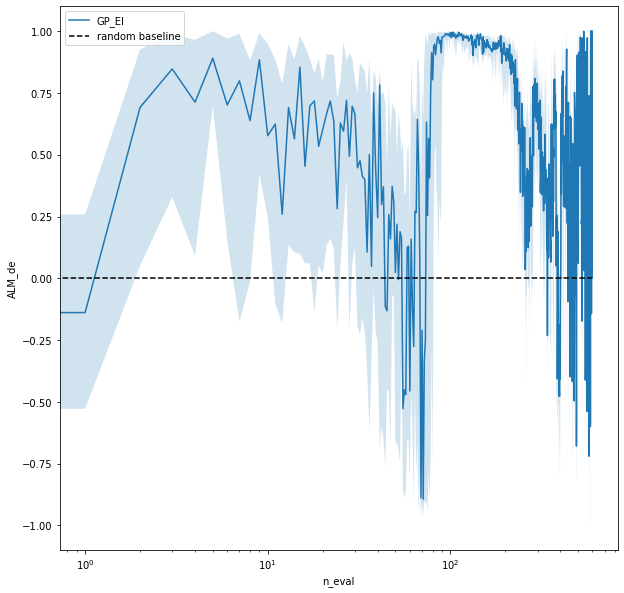

In [68]:
ALM_de_GP_EI = ALM_de(x_GP_EI[2])
# ALM_de_GP_LCB11 = ALM_de(x_GP_LCB11[2])


# ALM_de_RF_EI = ALM_de(x_RF_EI[2])
# ALM_de_RF_LCB11 = ALM_de(x_RF_LCB11[2])

# ALM_de_RF_LCB10 = ALM_de(x_RF_LCB10[2])
# ALM_de_RF_LCB01 = ALM_de(x_RF_LCB01[2])
# ALM_de_RF_LCB7525 = ALM_de(x_RF_LCB7525[2])



fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


ax0.plot(ALM_de_GP_EI[2], label = 'GP_EI')
ax0.fill_between(np.arange(len(ALM_de_GP_EI[2])), ALM_de_GP_EI[3], ALM_de_GP_EI[4], alpha=0.2)

# ax0.plot(ALM_de_GP_LCB11[2], label = 'GP_LCB11')
# ax0.fill_between(np.arange(len(ALM_de_GP_LCB11[2])), ALM_de_GP_LCB11[3], ALM_de_GP_LCB11[4], alpha=0.2)


# ax0.plot(ALM_de_RF_EI[2], label = 'RF_EI')
# ax0.fill_between(np.arange(len(ALM_de_RF_EI[2])), ALM_de_RF_EI[3], ALM_de_RF_EI[4], alpha=0.2)

# ax0.plot(ALM_de_RF_LCB11[2], label = 'RF_LCB11')
# ax0.fill_between(np.arange(len(ALM_de_RF_LCB11[2])), ALM_de_RF_LCB11[3], ALM_de_RF_LCB11[4], alpha=0.2)


# ax0.plot(ALM_de_RF_LCB10[2], label = 'RF_LCB10')
# ax0.plot(ALM_de_RF_LCB01[2], label = 'RF_LCB01')
# ax0.plot(ALM_de_RF_LCB7525[2], label = 'RF_LCB7525')


ax0.plot(np.linspace(0, nsteps-1, nsteps), np.zeros(nsteps),'--',color='black',label='random baseline')

ax0.legend()
ax0.set_xscale('log')
ax0.set_ylabel('ALM_de')
ax0.set_xlabel('n_eval')

In [69]:
# http://www.rsc.org/suppdata/c9/sc/c9sc05999g/c9sc05999g1.pdf
def P_rand(nn):
    x_random = np.arange(nn)
    
    M = n_top
    N = nn
    
    P = np.array([None for i in x_random])
    E = np.array([None for i in x_random])
    A = np.array([None for i in x_random])
    cA = np.array([None for i in x_random])
    
    P[0] = M / N
    E[0] = M / N
    A[0] = M / N
    cA[0] = A[0]
    

    for i in x_random[1:]:
        P[i] = (M - E[i-1]) / (N - i)
        E[i] = np.sum(P[:(i+1)])
        j = 0
        A_i = P[i]
        while j < i:
            A_i *= (1 - P[j])
            j+=1
        A[i] = A_i
        cA[i] = np.sum(A[:(i+1)])
        
#     print(A)
        
    return E / M, cA

In [70]:
seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3]
# seed_list = [5, 892, 91, 2345, 391]

def aggregation_all(seed, n_runs, n_fold):
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    random.seed(seed)
    
    index_runs = list(np.arange(n_runs))
    
    agg_list = []
    
    i = 0
    
    while i < n_fold:
    
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
            
        agg_list.append(index_i)
        
        i += 1
#     print(agg_list)    
    return agg_list


In [71]:
def avg_all(x):
#     nsteps
    n_eval = len(x[0]) 
    
#     fold
    n_fold = 5
    
#     rows = # of ensembles = 50
    n_runs = len(x)
    print(n_runs, n_fold)
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
#     # of seeds 
    n_sets = len(seed_list)
    
    l_index_list = []
    
    for i in np.arange(n_sets):
        
        s = aggregation_all(seed_list[i], n_runs, n_fold)
        l_index_list.extend(s)

#     rows in l_index_list

    assert len(l_index_list) == n_sets * n_fold
    

    
    l_avg_runs = []

    for i in np.arange(len(l_index_list)):
        
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            
            avg_run += np.array(x[j])
            
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    

    assert n_eval == len(l_avg_runs[0])
    
    return l_avg_runs 
    
def ALM_all(l_avg_runs):
    
    n_eval = len(l_avg_runs[0])
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    

    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
        
        
    return np.array(median_) / n_top, np.array(low_q) / n_top, np.array(high_q) / n_top



In [72]:
# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

TopPercent = 3

i_ = TopPercent

# ALM_all_GP_LCB11 = ALM_all(avg_all(x_GP_LCB11[i_]))
ALM_all_GP_EI = ALM_all(avg_all(x_GP_EI[i_]))


# ALM_all_RF_LCB11 = ALM_all(avg_all(x_RF_LCB11[i_]))
# ALM_all_RF_EI = ALM_all(avg_all(x_RF_EI[i_]))

                        
# ALM_all_RF_LCB10 = ALM_all(avg_all(x_RF_LCB10[i_]))
# ALM_all_RF_LCB01 = ALM_all(avg_all(x_RF_LCB01[i_]))
# ALM_all_RF_LCB7525 = ALM_all(avg_all(x_RF_LCB7525[i_]))



26 5


AssertionError: 

Text(0.5, 0, 'n_eval')

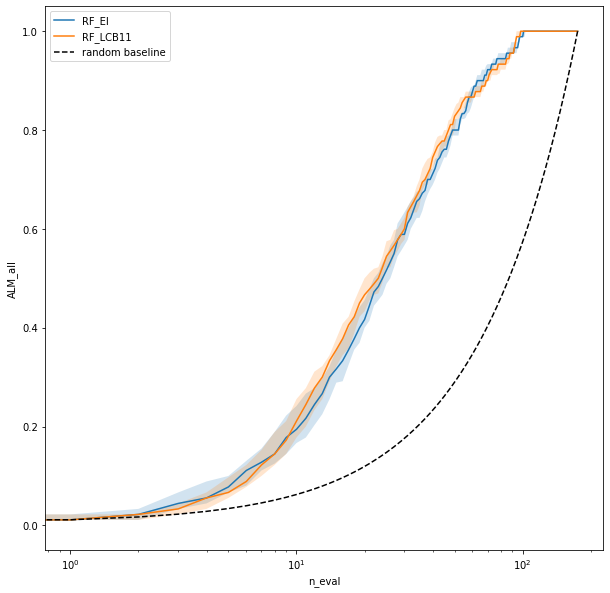

In [62]:
# np.array(median_), np.array(low_q), np.array(high_q)


fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

# ax0.plot(ALM_all_GP_EI[0], label = 'GP_EI')
# ax0.fill_between(np.arange(len(ALM_all_GP_EI[0])), ALM_all_GP_EI[1], ALM_all_GP_EI[2], alpha=0.2)

# ax0.plot(ALM_all_GP_LCB11[0], label = 'GP_LCB11')
# ax0.fill_between(np.arange(len(ALM_all_GP_LCB11[0])), ALM_all_GP_LCB11[1], ALM_all_GP_LCB11[2], alpha=0.2)


ax0.plot(ALM_all_RF_EI[0], label = 'RF_EI')
ax0.fill_between(np.arange(len(ALM_all_RF_EI[0])), ALM_all_RF_EI[1], ALM_all_RF_EI[2], alpha=0.2)

ax0.plot(ALM_all_RF_LCB11[0], label = 'RF_LCB11')
ax0.fill_between(np.arange(len(ALM_all_RF_LCB11[0])), ALM_all_RF_LCB11[1], ALM_all_RF_LCB11[2], alpha=0.2)


# ax0.plot(ALM_all_RF_LCB01[0], label = 'RF_LCB01')
# ax0.fill_between(np.arange(len(ALM_all_RF_LCB01[0])), ALM_all_RF_LCB01[1], ALM_all_RF_LCB01[2], alpha=0.2)

# ax0.plot(ALM_all_RF_LCB10[0], label = 'RF_LCB10')
# ax0.fill_between(np.arange(len(ALM_all_RF_LCB10[0])), ALM_all_RF_LCB10[1], ALM_all_RF_LCB10[2], alpha=0.2)

# ax0.plot(ALM_all_RF_LCB7525[0], label = 'RF_LCB7525')
# ax0.fill_between(np.arange(len(ALM_all_RF_LCB7525[0])), ALM_all_RF_LCB7525[1], ALM_all_RF_LCB7525[2], alpha=0.2)




ax0.plot(np.arange(len(ALM_all_RF_LCB11[0])), P_rand(len(ALM_all_RF_LCB11[0]))[0],'--',color='black',label='random baseline')

ax0.legend()
# ax0.set_ylabel('loss')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([0, 500])
# ax0.set_ylim([0, 2])
ax0.set_xscale('log')
ax0.set_ylabel('ALM_all')
ax0.set_xlabel('n_eval')



In [93]:
np.round(ALM_all_GP_LCB11[0], decimals = 5)

array([0.     , 0.01111, 0.02222, 0.04444, 0.06667, 0.08889, 0.12222,
       0.12778, 0.13333, 0.15556, 0.16667, 0.17222, 0.18889, 0.21667,
       0.24444, 0.25556, 0.28333, 0.31111, 0.32222, 0.32222, 0.34444,
       0.35556, 0.36667, 0.37778, 0.38889, 0.41111, 0.42222, 0.43333,
       0.44444, 0.46111, 0.47222, 0.48333, 0.48889, 0.5    , 0.52222,
       0.52778, 0.56667, 0.58889, 0.61111, 0.63333, 0.65556, 0.67778,
       0.67778, 0.7    , 0.7    , 0.71111, 0.71111, 0.71667, 0.72222,
       0.73333, 0.73333, 0.75556, 0.75556, 0.75556, 0.75556, 0.76667,
       0.76667, 0.77778, 0.77778, 0.77778, 0.77778, 0.78889, 0.78889,
       0.78889, 0.78889, 0.78889, 0.8    , 0.8    , 0.81111, 0.81111,
       0.82222, 0.82222, 0.83333, 0.83333, 0.84444, 0.84444, 0.85556,
       0.85556, 0.85556, 0.86667, 0.87778, 0.87778, 0.88889, 0.88889,
       0.9    , 0.91111, 0.92222, 0.92222, 0.94444, 0.95556, 0.96667,
       0.97778, 0.97778, 0.98889, 0.98889, 0.98889, 0.98889, 1.     ,
       1.     , 1.  

In [87]:
np.round(P_rand(len(ALM_all_RF_LCB11[0]))[0].astype(np.double), 5)

array([0.00568, 0.01136, 0.01705, 0.02273, 0.02841, 0.03409, 0.03977,
       0.04545, 0.05114, 0.05682, 0.0625 , 0.06818, 0.07386, 0.07955,
       0.08523, 0.09091, 0.09659, 0.10227, 0.10795, 0.11364, 0.11932,
       0.125  , 0.13068, 0.13636, 0.14205, 0.14773, 0.15341, 0.15909,
       0.16477, 0.17045, 0.17614, 0.18182, 0.1875 , 0.19318, 0.19886,
       0.20455, 0.21023, 0.21591, 0.22159, 0.22727, 0.23295, 0.23864,
       0.24432, 0.25   , 0.25568, 0.26136, 0.26705, 0.27273, 0.27841,
       0.28409, 0.28977, 0.29545, 0.30114, 0.30682, 0.3125 , 0.31818,
       0.32386, 0.32955, 0.33523, 0.34091, 0.34659, 0.35227, 0.35795,
       0.36364, 0.36932, 0.375  , 0.38068, 0.38636, 0.39205, 0.39773,
       0.40341, 0.40909, 0.41477, 0.42045, 0.42614, 0.43182, 0.4375 ,
       0.44318, 0.44886, 0.45455, 0.46023, 0.46591, 0.47159, 0.47727,
       0.48295, 0.48864, 0.49432, 0.5    , 0.50568, 0.51136, 0.51705,
       0.52273, 0.52841, 0.53409, 0.53977, 0.54545, 0.55114, 0.55682,
       0.5625 , 0.56

In [95]:
def EF(x):
    
    n_eval = len(x)

    ALM_ALL_RS = P_rand(n_eval)[0]
    
    l_EF = []
    
    for j in np.arange(n_eval):
        l_EF.append(x[j] / ALM_ALL_RS[j])
        
    return l_EF
  

# def AF(x):
    
#     n_eval = len(x)

#     ALM_RS = P_rand(n_eval)[0]
    
#     l_ALM = []
#     l_AF = []
    
#     for j in np.arange(n_eval):
#         ALM_RS_j = ALM_RS[j]
#         n_rs = j + 1  
#         l_ALM.append(ALM_RS_j)
        
#         delta = 10**10
#         n_opt = None
#         for s in np.arange(n_eval):
#             if abs(ALM_RS_j - x[s]) < delta:
#                 delta = abs(ALM_RS_j - x[s])
#                 n_opt = s + 1
                
#         AF = n_rs / n_opt
#         l_AF.append(AF)
        
#     return l_ALM, l_AF

def AF(x):
    
    n_eval = len(x)

#     ALM_RS = P_rand(n_eval)[0]
    ALM_RS = np.round(P_rand(len(ALM_all_RF_LCB11[0]))[0].astype(np.double), 5)
    
    l_ALM = []
    l_AF = []
    
    
    for j in np.arange(n_eval):
        ALM_j = x[j]
        n_opt = j + 1  
        l_ALM.append(ALM_j)
        
        
        delta = 10**10
        n_rs = None
        for s in np.arange(n_eval):
            if abs(ALM_j - ALM_RS[s]) < delta:
                delta = abs(ALM_j - ALM_RS[s])
                n_rs = s + 1
                
        AF = n_rs / n_opt
        l_AF.append(AF)
        
    return l_ALM, l_AF




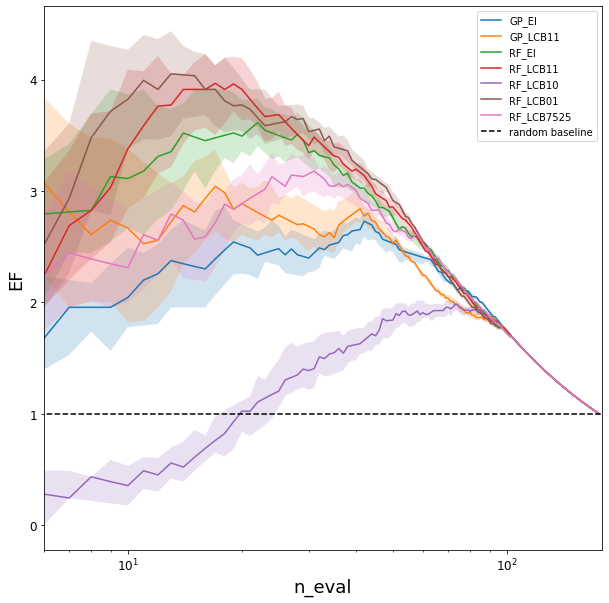

In [96]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(EF(ALM_all_GP_EI[0]), label = 'GP_EI')
ax0.fill_between(np.arange(len(EF(ALM_all_GP_EI[0]))), EF(ALM_all_GP_EI[1]), EF(ALM_all_GP_EI[2]), alpha=0.2)

ax0.plot(EF(ALM_all_GP_LCB11[0]), label = 'GP_LCB11')
ax0.fill_between(np.arange(len(EF(ALM_all_GP_LCB11[0]))), EF(ALM_all_GP_LCB11[1]), EF(ALM_all_GP_LCB11[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_EI[0]), label = 'RF_EI')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_EI[0]))), EF(ALM_all_RF_EI[1]), EF(ALM_all_RF_EI[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_LCB11[0]), label = 'RF_LCB11')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB11[0]))), EF(ALM_all_RF_LCB11[1]), EF(ALM_all_RF_LCB11[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_LCB10[0]), label = 'RF_LCB10')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB10[0]))), EF(ALM_all_RF_LCB10[1]), EF(ALM_all_RF_LCB10[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_LCB01[0]), label = 'RF_LCB01')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB01[0]))), EF(ALM_all_RF_LCB01[1]), EF(ALM_all_RF_LCB01[2]), alpha=0.2)

ax0.plot(EF(ALM_all_RF_LCB7525[0]), label = 'RF_LCB7525')
ax0.fill_between(np.arange(len(EF(ALM_all_RF_LCB7525[0]))), EF(ALM_all_RF_LCB7525[1]), EF(ALM_all_RF_LCB7525[2]), alpha=0.2)


ax0.plot(np.linspace(0, nsteps-1, nsteps), np.ones(nsteps),'--',color='black',label='random baseline')        

ax0.legend()
ax0.set_ylabel('EF', fontsize=18)
ax0.tick_params(axis='y', labelsize=12)

ax0.set_xlabel('n_eval', fontsize=18)
ax0.tick_params(axis='x', labelsize=12)
# ax0.set_title('median')
ax0.set_xlim([6, 178])
# ax0.set_ylim([0, 2])
ax0.set_xscale('log')
# ax0.set_yscale('log')
        
    

Text(0.5, 0, 'ALM_all')

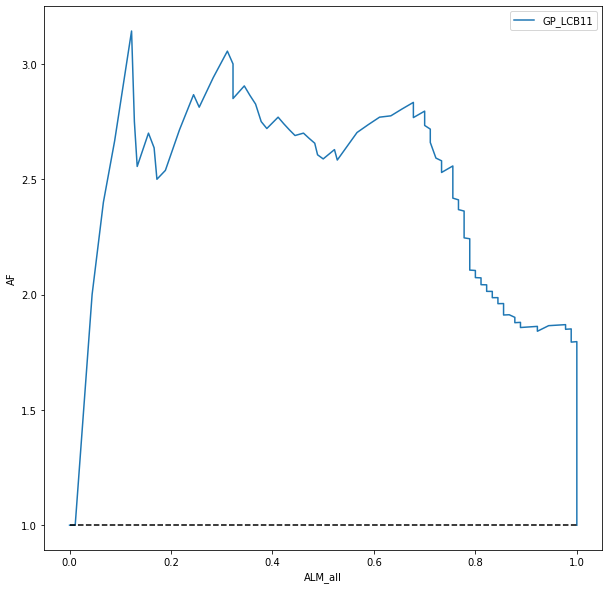

In [153]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(AF(np.round(ALM_all_GP_LCB11[0], decimals = 5))[0], AF(np.round(ALM_all_GP_LCB11[0], decimals = 5))[1], label = 'GP_LCB11')
# ax0.fill_between(AF(ALM_all_GP_LCB11[1])[0], AF(ALM_all_GP_LCB11[1])[1], AF(ALM_all_GP_LCB11[2])[1], alpha=0.2)


# ax0.scatter(AF(ALM_all_GP_LCB11[0])[0], AF(ALM_all_GP_LCB11[0])[1])
# ax0.plot(AF(ALM_all_GP_LCB11[1])[0], AF(ALM_all_GP_LCB11[1])[1], label = 'GP_LCB')
# ax0.plot(AF(ALM_all_GP_LCB11[2])[0], AF(ALM_all_GP_LCB11[2])[1], label = 'GP_LCB')
# ax0.fill_between(AF(ALM_all_GP_LCB11[2])[0], AF(ALM_all_GP_LCB11[1])[1], AF(ALM_all_GP_LCB11[2])[1], alpha=0.2)


# ax0.plot(AF(ALM_all_RF_LCB11[0])[0], AF(ALM_all_RF_LCB11[0])[1], label = 'RF_LCB11')
# ax0.plot(AF(ALM_all_RF_LCB10[0])[0], AF(ALM_all_RF_LCB10[0])[1], label = 'RF_LCB10')
# ax0.plot(AF(ALM_all_RF_LCB01[0])[0], AF(ALM_all_RF_LCB01[0])[1], label = 'RF_LCB01')
# ax0.plot(AF(ALM_all_RF_LCB7525[0])[0], AF(ALM_all_RF_LCB7525[0])[1], label = 'RF_LCB7525')

ax0.plot(np.linspace(0, 1, 176), np.ones(176),'--',color='black',label=None)        
        

ax0.legend()
ax0.set_ylabel('AF')
ax0.set_xlabel('ALM_all')
# ax0.set_title('median')
# ax0.set_xlim([8, nn])
# ax0.set_ylim([0, 2])
# ax0.set_xscale('log')
# ax0.set_yscale('log')

In [100]:
def found(index_list, top_list):
    
    assert len(index_list) > len(top_list)
    
    l = [0 for i in index_list]
    
    found = False
    
    for i in np.arange(len(index_list)):
        if found == False:
            if index_list[i] in top_list:
                l[i] = 1
                found = True
        else:
            l[i] = 1
            
    return np.array(l)


def aggregation_any(seed, n_runs, n_fold):
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    random.seed(seed)
    
    index_runs = list(np.arange(n_runs))
    
    agg_list = []
    
    i = 0
    
    while i < n_fold:
    
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
            
        agg_list.append(index_i)
        
        i += 1
        
    return agg_list

def avg_any(x):
#     nsteps
    n_eval = len(x[0]) 
    
#     fold
    n_fold = 5
    
#     rows = # of ensembles = 25
    n_runs = len(x)
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
#     # of seeds 
    n_sets = len(seed_list)
    
    l_index_list = []
    
    for i in np.arange(n_sets):
        
        s = aggregation_any(seed_list[i], n_runs, n_fold)
        l_index_list.extend(s)

#     rows in l_index_list

    assert len(l_index_list) == n_sets * n_fold
    

    
    l_avg_runs = []

    for i in np.arange(len(l_index_list)):
        
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            
            avg_run += found(x[j], top_indices)
            
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    

    assert n_eval == len(l_avg_runs[0])
    
    return l_avg_runs 
    
def ALM_any(l_avg_runs):
    
    n_eval = len(l_avg_runs[0])
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    

    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
        
        
    return np.array(median_), np.array(low_q), np.array(high_q)

In [101]:
# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

index_ = 0

i_ = index_

ALM_any_GP_EI = ALM_any(avg_any(x_GP_EI[i_]))
ALM_any_GP_LCB11 = ALM_any(avg_any(x_GP_LCB11[i_]))


ALM_any_RF_EI = ALM_any(avg_any(x_RF_EI[i_]))
ALM_any_RF_LCB11 = ALM_any(avg_any(x_RF_LCB11[i_]))


ALM_any_RF_LCB10 = ALM_any(avg_any(x_RF_LCB10[i_]))
ALM_any_RF_LCB01 = ALM_any(avg_any(x_RF_LCB01[i_]))
ALM_any_RF_LCB7525 = ALM_any(avg_any(x_RF_LCB7525[i_]))

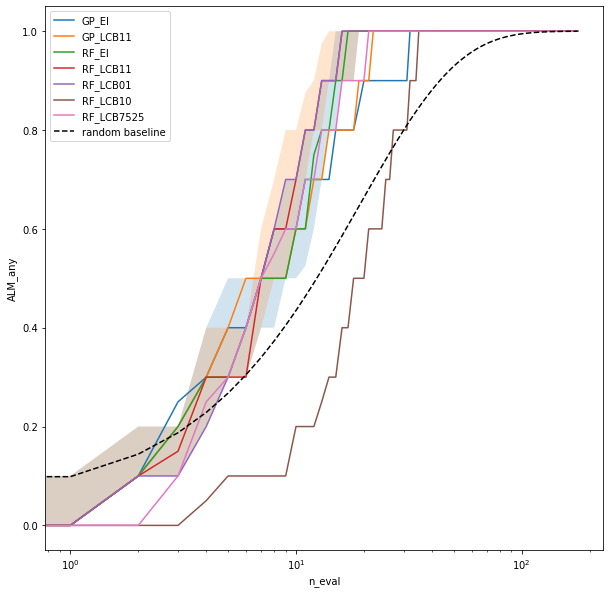

In [103]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(ALM_any_GP_EI[0], label = 'GP_EI')
# ax0.fill_between(np.arange(len(ALM_any_GP_EI[0])), ALM_any_GP_EI[1], ALM_any_GP_EI[2], alpha=0.2)

ax0.plot(ALM_any_GP_LCB11[0], label = 'GP_LCB11')
# ax0.fill_between(np.arange(len(ALM_any_GP_LCB11[0])), ALM_any_GP_LCB11[1], ALM_any_GP_LCB11[2], alpha=0.2)

ax0.plot(ALM_any_RF_EI[0], label = 'RF_EI')
ax0.fill_between(np.arange(len(ALM_any_RF_EI[0])), ALM_any_RF_EI[1], ALM_any_RF_EI[2], alpha=0.2)

ax0.plot(ALM_any_RF_LCB11[0], label = 'RF_LCB11')
ax0.fill_between(np.arange(len(ALM_any_RF_LCB11[0])), ALM_any_RF_LCB11[1], ALM_any_RF_LCB11[2], alpha=0.2)

ax0.plot(ALM_any_RF_LCB01[0], label = 'RF_LCB01')
# ax0.fill_between(np.arange(len(ALM_any_RF_LCB01[0])), ALM_any_RF_LCB01[1], ALM_any_RF_LCB01[2], alpha=0.2)

ax0.plot(ALM_any_RF_LCB10[0], label = 'RF_LCB10')
# ax0.fill_between(np.arange(len(ALM_any_RF_LCB10[0])), ALM_any_RF_LCB10[1], ALM_any_RF_LCB10[2], alpha=0.2)

ax0.plot(ALM_any_RF_LCB7525[0], label = 'RF_LCB7525')
# ax0.fill_between(np.arange(len(ALM_any_RF_LCB7525[0])), ALM_any_RF_LCB7525[1], ALM_any_RF_LCB7525[2], alpha=0.2)
        
    
ax0.plot(np.arange(len(ALM_any_GP_LCB11[0])), P_rand(len(ALM_any_GP_LCB11[0]))[1],'--',color='black',label='random baseline')    
        

ax0.legend()
ax0.set_ylabel('ALM_any')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([-10, nn+1000])
# ax0.set_ylim([0, 2])
ax0.set_xscale('log')
# ax0.set_yscale('log')

In [71]:
def EF_any(x):
    
    n_eval = len(x)

    ALM_ANY_RS = P_rand(n_eval)[1]
    
    l_EF = []
    
    for j in np.arange(n_eval):
        l_EF.append(x[j] / ALM_ANY_RS[j])
        
    return l_EF
  

# def AF_any(x):
#     n_eval = len(x)

#     ALM_ANY_RS = P_rand(n_eval)[1]
    
#     l_ALM = []
#     l_AF = []
    
#     for j in np.arange(n_eval):
#         n_eval_opt = j
#         ALM = x[j]
#         l_ALM.append(ALM)
#         n_eval_rs = ALM * (n_eval - 1)
#         AF = n_eval_rs / n_eval_opt
#         l_AF.append(AF)
        
#     return l_ALM, l_AF

def AF(x):
    
    n_eval = len(x)

    ALM_RS = P_rand(n_eval)[1]
    
    l_ALM = []
    l_AF = []
    
    
    for j in np.arange(n_eval):
        ALM_j = x[j]
        n_opt = j + 1  
        l_ALM.append(ALM_j)
        
        
        delta = 10**10
        n_rs = None
        for s in np.arange(n_eval):
            if abs(ALM_j - ALM_RS[s]) < delta:
                delta = abs(ALM_j - ALM_RS[s])
                n_rs = s + 1
                
        AF = n_rs / n_opt
        l_AF.append(AF)
        
    return l_ALM, l_AF

In [124]:
ARD_ = False

Bias_kernel = GPy.kern.Bias(X_feature.shape[1], variance=1.)

Matern52_kernel = GPy.kern.Matern52(X_feature.shape[1], variance=1., ARD=ARD_) + Bias_kernel

n_est = 50

In [137]:
def calc_MAE_GP(test_index, SL_model):
    SL_mae = 0
    
    for index in test_index:
        X_test = X_feature[index]
        y_test = y[index]
        
        X_test = X_test.reshape([1,X_feature.shape[1]])
        
        SL_mean, SL_std = SL_model.predict(X_test)[0][0][0], SL_model.predict(X_test)[1][0][0]
        
        sl_mae = (y_test - SL_mean)**2 
        SL_mae += sl_mae       
    
    return SL_mae / len(test_index)

def GP_MAE_full():
    
    seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3, 84,7646,6207,4530,8206,6260,2342,3112,5187,2737,8979,4018,8223,1678,9481,2232,
             461,7694,6091, 3189,2480,9106,1316,8500,2531,5329,9872,1388,8805,2726,119,3416,7747,3927,138,1488,232,4564,3492,9841]
    
    total_mae = 0
    
    for s in seed_list:
        
        index_test = list(np.arange(len(y)))
        n_train = int(math.ceil(len(y) * 0.70))
    
        index_train = random.sample(index_test, n_train)
        
        X_train = []
        y_train = []
        
        for i in index_train:
            X_train.append(X_feature[i])
            y_train.append(y[i])
            index_test.remove(i)
        
        GP_train = GPy.models.GPRegression(X = np.array(X_train), 
                                           Y = np.array([[i] for i in y_train]), 
                                           kernel= Matern52_kernel,
                                           noise_var = 0.01
                                          )

        GP_train.optimize_restarts(num_restarts=10,
                                   parallel = True,
                                   robust = True,
                                   optimizer = 'bfgs',
                                   max_iters=100,
                                   verbose = False)
        
        total_mae += calc_MAE_GP(index_test, GP_train)
        
    return total_mae / len(seed_list)

def calc_MAE_RF(test_index, RF_model):
    RF_mae = 0
    for index in test_index:
        X_test = X_feature[index]
        y_test = y[index]

        tree_predictions = []
        for j in np.arange(n_est):
            tree_predictions.append((RF_model.estimators_[j].predict(np.array([X_test]))).tolist())
        mean = np.mean(np.array(tree_predictions), axis=0)[0]

        std = np.std(np.array(tree_predictions), axis=0)[0]

        mae_ = (y_test - mean)**2 
        RF_mae += mae_
        
    return RF_mae / len(test_index)

def RF_MAE_full():
    
    seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3, 84,7646,6207,4530,8206,6260,2342,3112,5187,2737,8979,4018,8223,1678,9481,2232,
             461,7694,6091, 3189,2480,9106,1316,8500,2531,5329,9872,1388,8805,2726,119,3416,7747,3927,138,1488,232,4564,3492,9841]
    
    total_mae = 0
    
    for s in seed_list:
        
        index_test = list(np.arange(len(y)))
        n_train = int(math.ceil(len(y) * 0.70))
    
        index_train = random.sample(index_test, n_train)
        
        X_train = []
        y_train = []
        
        for i in index_train:
            X_train.append(X_feature[i])
            y_train.append(y[i])
            index_test.remove(i)
        
        RF_model = RandomForestRegressor(n_estimators= n_est)
        RF_model.fit(X_train, y_train)
        
        total_mae += calc_MAE_RF(index_test, RF_model)
        
    return total_mae / len(seed_list)

    

In [138]:
GP_MAE_full = GP_MAE_full()

In [139]:
GP_MAE_full

0.34454852754952

In [140]:
RF_MAE_full = RF_MAE_full()

In [141]:
RF_MAE_full

0.3282099902890576

Text(0.5, 0, 'n_eval')

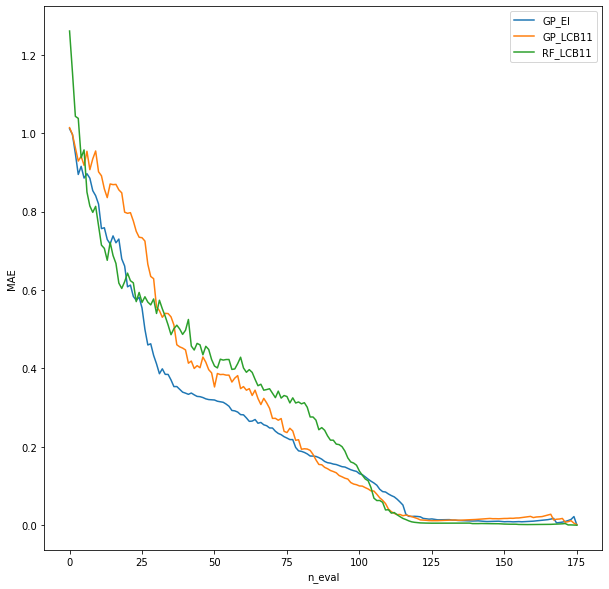

In [154]:
def average_run(x):
#     rows
    n_runs = len(x)
#     columns
    n_eval = len(x[0])
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    six_ = [None for i in np.arange(n_eval)]
    nintyfour_ = [None for i in np.arange(n_eval)]
    

    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(n_runs):
            i_column.append(x[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        six_[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        nintyfour_[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
        
        
    return np.array(median_), np.array(six_), np.array(nintyfour_)




# [index_collection, X_collection, y_collection, TopPercent_collection, MAE_collection]

MAE = 4

i_ = MAE

MAE_GP_EI = average_run(x_GP_EI[i_])
MAE_GP_LCB11 = average_run(x_GP_LCB11[i_])


MAE_RF_EI = average_run(x_RF_EI[i_])
MAE_RF_LCB11 = average_run(x_RF_LCB11[i_])

MAE_RF_LCB10 = average_run(x_RF_LCB10[i_])
MAE_RF_LCB01 = average_run(x_RF_LCB01[i_])
MAE_RF_LCB7525 = average_run(x_RF_LCB7525[i_])


fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)

ax0.plot(MAE_GP_EI[0], label = 'GP_EI')
# ax0.fill_between(np.arange(len(MAE_GP_EI[0])), MAE_GP_EI[1], MAE_GP_EI[2], alpha=0.2)

ax0.plot(MAE_GP_LCB11[0], label = 'GP_LCB11')
# ax0.fill_between(np.arange(len(MAE_GP_LCB[0])), MAE_GP_LCB[1], MAE_GP_LCB[2], alpha=0.2)


# ax0.plot(MAE_RF_EI[0], label = 'RF_EI')
# # ax0.fill_between(np.arange(len(MAE_RF_EI[0])), MAE_RF_EI[1], MAE_RF_EI[2], alpha=0.2)

ax0.plot(MAE_RF_LCB11[0], label = 'RF_LCB11')
# ax0.fill_between(np.arange(len(MAE_RF_LCB11[0])), MAE_RF_LCB11[1], MAE_RF_LCB11[2], alpha=0.2)
# 
# ax0.plot(MAE_RF_LCB10[0], label = 'RF_LCB10')
# ax0.plot(MAE_RF_LCB01[0], label = 'RF_LCB01')
# ax0.plot(MAE_RF_LCB7525[0], label = 'RF_LCB7525')
        

ax0.legend()
ax0.set_ylabel('MAE')
ax0.set_xlabel('n_eval')
# ax0.set_title('median')
# ax0.set_xlim([0, int(math.ceil(len(y)*0.70))])
# ax0.set_ylim([0, 2])
# ax0.set_xscale('log')
# ax0.set_yscale('log')

In [ ]:
def EF(l_avg_runs):
    
    n_eval = len(l_avg_runs[0])

    x_random = np.linspace(0, n_eval-1, n_eval)
    ALM_ALL_RS = 1/(n_eval-1) * x_random
    
    l_EF = []
    
    for i in np.arange(len(l_avg_runs)):
        EF_i = []
        for j in np.arange(n_eval):
            EF_i.append(l_avg_runs[i][j] / ALM_ALL_RS[j])
        l_EF.append(EF_i)   
    
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_EF)):
            i_column.append(l_EF[j][i])
        
        i_column = np.array(i_column)
        median_[i] = np.median(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
    
    return np.array(median_)/ n_top, np.array(low_q)/ n_top, np.array(high_q)/ n_top
  

def AF(l_avg_runs):
    n_eval = len(l_avg_runs[0])

    x_random = np.linspace(0, n_eval-1, n_eval)
    ALM_ALL_RS = 1/(n_eval-1) * x_random
    
    l_ALM = []
    l_AF = []
    
    for i in np.arange(len(l_avg_runs)):
        ALM_i = []
        AF_i = []
        for j in np.arange(n_eval):
            n_eval_opt = j
            ALM = l_avg_runs[i][j]
            ALM_i.append(ALM)
            n_eval_rs = ALM * (n_eval - 1)
            AF = n_eval_rs / n_eval_opt
            AF_i.append(AF)
        l_ALM.append(ALM_i)
        l_AF.append(AF_i)
        
    ALM_median_ = [None for i in np.arange(n_eval)]
    ALM_low_q = [None for i in np.arange(n_eval)]
    ALM_high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_ALM)):
            i_column.append(l_ALM[j][i])

        ALM_median_[i] = np.median(i_column)
        ALM_low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        ALM_high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')   
    
    AF_median_ = [None for i in np.arange(n_eval)]
    AF_low_q = [None for i in np.arange(n_eval)]
    AF_high_q = [None for i in np.arange(n_eval)]
    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_AF)):
            i_column.append(l_AF[j][i])

        AF_median_[i] = np.median(i_column)
        AF_low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        AF_high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')   
        
    return np.array(ALM_median_)/ n_top, np.array(ALM_low_q)/ n_top, np.array(ALM_high_q)/ n_top, np.array(AF_median_)/ n_top, np.array(AF_low_q)/ n_top, np.array(AF_high_q)/ n_top